## 0. Initialize Packages

In [91]:
#!pip3 install  sentence-transformers
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('all-MiniLM-L6-v2')


In [86]:
import seaborn as sns
from scipy.stats import kstest

import pandas as pd
import numpy as np
import torch
from transformers import BertTokenizer, BertModel
import logging
import matplotlib.pyplot as plt


from numpy import dot
from numpy.linalg import norm
!pip3 install umap
import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics.pairwise import cosine_similarity
import sys
import os

import plotly.express as px
import plotly.offline as pyo

import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"

import os.path
import json
import random
from sklearn.manifold import TSNE

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## 1. Get Data

In [87]:
df = pd.read_excel('/Users/eotenen/Library/Containers/com.microsoft.Excel/Data/Desktop/scales_items.xlsx', header=None)
df.columns = ['orientation','source','text']

## 1.1. Clean Space in text

In [88]:
df.text = [s.strip() for s in df.text]


array(['left', 'right', nan], dtype=object)

In [89]:
df= df[~df['orientation'].isna()]


## 2. Get Embeddings

In [92]:
#Story
text_emb = []
for text in df.text:
    embeddings = model.encode(text)
    text_emb.append(embeddings)
df['text_emb'] = text_emb



## 2.1.2. Dimensionality Reduction

In [94]:
def get_transform(data, method, n_dim=2):
    """ Implements transformation of high-dimensional data using UMAP and PCA, either seperately or in tandem. 

    Args:
        data (Series): Set of vectors to be transformed. 
        method (String - 'umap', 'pca', or 'both'): Defines which transformation methods to use. If both, function will first run PCA, then run UMAP on the results of the PCA transform.
        n_neighbors (int, optional): Parameter for UMAP. Defaults to 15.
        min_dist (float, optional): Parameter for UMAP. Defaults to 0.1.
        n_pca (int, optional): Dimensionality of vectors to be returned from PCA transform. Defaults to 50.
        n_umap (int, optional): Dimensionality of vectors to be returned from UMAP transform. Defaults to 2.
        metric (str, optional): Distance metric for UMAP. Defaults to 'euclidean'.

    Returns:
        tfm: array of transformed vectors 
    """
    if method.lower() == 'umap':
        fit = umap.umap.UMAP(
            #n_neighbors=n_neighbors,
            #min_dist=min_dist,
            n_components=n_dim,
            #metric=metric
        )
        tfm = fit.fit_transform(data)

    elif method.lower() == 'pca':
        fit = PCA(
            n_components=n_dim
        )
        tfm = fit.fit_transform(data)

    elif method.lower() == 'tsne':
        fit = TSNE(
            n_components=n_dim
        )
        tfm = fit.fit_transform(data)

    else:
        print(f'{method} is nanayed')

    print('done!')

    return fit, tfm

In [115]:
model, transformed_embeddings_pca = get_transform([*df.text_emb], method='pca', n_dim=2)
model, transformed_embeddings_tsne = get_transform(np.array(text_emb), method='tsne', n_dim=2)

done!
done!


In [116]:
transformed_embeddings_pca[:,0]
transformed_embeddings_pca[:,1] 

transformed_embeddings_pca_dict = dict(transformed_embeddings_pca)

### PCA 

In [117]:
data = []

df_subset = pd.DataFrame(data)


df_subset['pca-one'] = transformed_embeddings_pca[:,0]
df_subset['pca-two'] = transformed_embeddings_pca[:,1]

df_subset


,pca-one,pca-two
0,-0.214649,0.135744
1,-0.026645,0.364832
2,-0.413511,-0.132094
3,-0.422177,-0.192237
4,-0.220868,0.370606
...,...,...
60,-0.099003,0.365069
61,-0.208006,-0.135247
62,-0.139887,0.179806
63,-0.087973,0.516362


<Axes: xlabel='pca-one', ylabel='pca-two'>

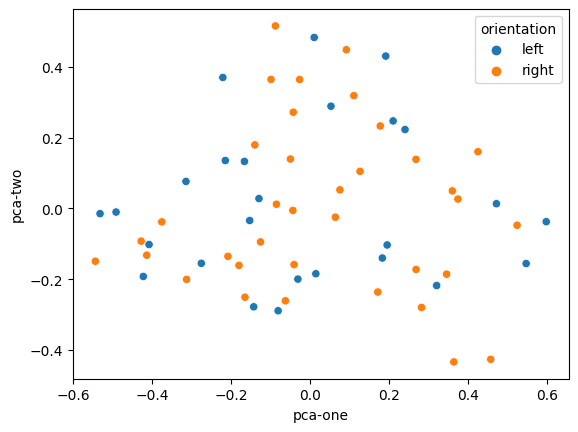

In [118]:
sns.scatterplot(
    x='pca-one', y='pca-two',
    hue=df.orientation,
    #style=df_all.no,
    #palette=sns.color_palette("hls", 464),
    data=df_subset,
    legend="full",
    
)

### TSNE

In [119]:
data = []

df_subset = pd.DataFrame(data)


df_subset['tsne-2d-one'] = transformed_embeddings_tsne[:,0]
df_subset['tsne-2d-two'] = transformed_embeddings_tsne[:,1]

df_subset

,tsne-2d-one,tsne-2d-two
0,-1.340048,-3.442913
1,-0.188384,-1.862803
2,-3.958693,1.399205
3,-3.920310,0.118410
4,-1.011279,0.493853
...,...,...
60,-0.775970,0.727764
61,-3.134345,-0.793220
62,-1.722667,1.465814
63,-0.275166,-0.149233


/var/folders/l4/1xnf5c593754ph42_t0k68480000gq/T/ipykernel_12244/165992869.py:2: UserWarning:

The palette list has more values (4) than needed (2), which may not be intended.



<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

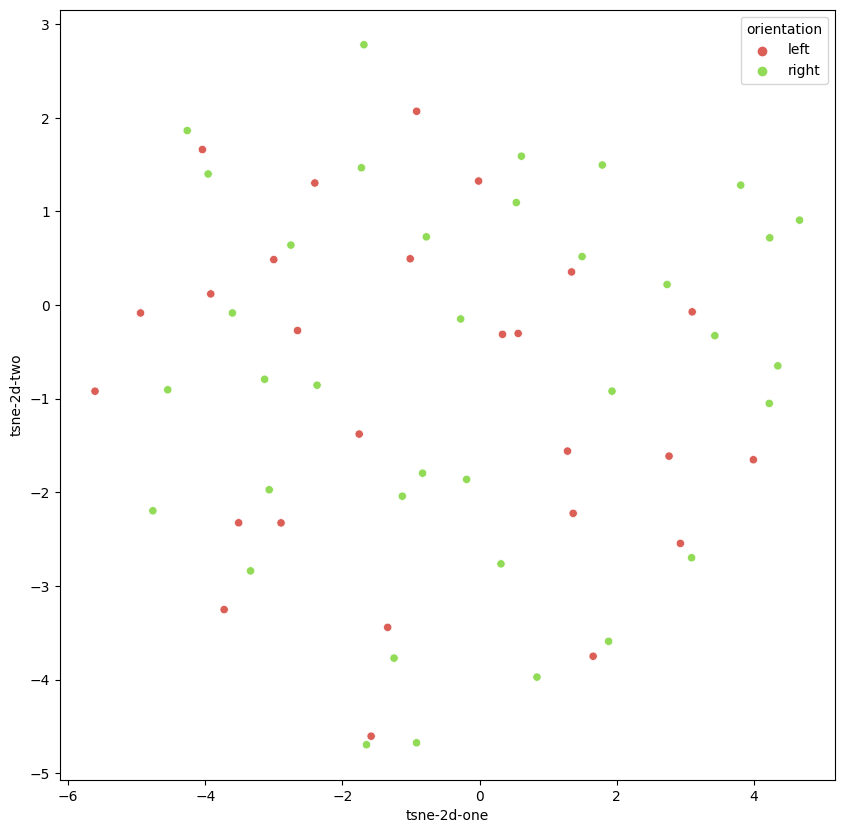

In [120]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=df.orientation,
    #style=df_all.gen,
    palette=sns.color_palette("hls", 4),
    color = df_subset,
    data=df_subset,
    legend="full",
    alpha=1
)

<Axes: xlabel='tsne-2d-one', ylabel='tsne-2d-two'>

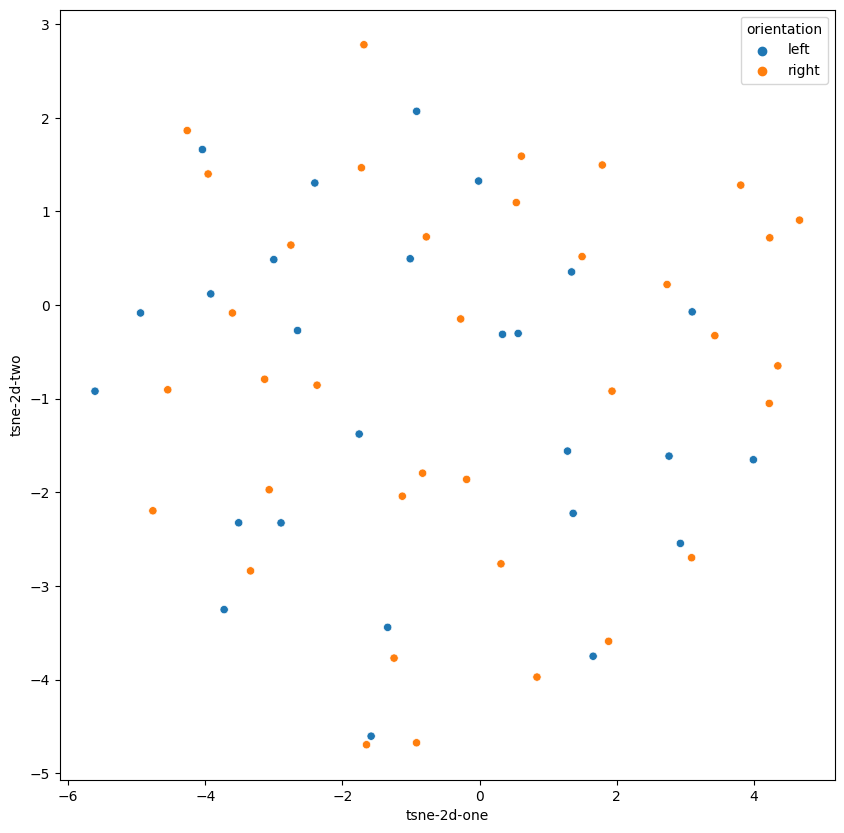

In [121]:
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue=df.orientation,
    #palette=sns.color_palette("hls", 464),
    data=df_subset,
    legend="full",
    alpha=1
)